## Librerías

In [1]:
import open3d as o3d
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
import random
import seaborn as sns
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt 
from plotly.offline import iplot, init_notebook_mode

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## DataLoader

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import cKDTree

category_mapping = {
    0: [43, 38, 58, 29, 41, 42, 44, 39, 55],  # Construction
    1: [4, 45, 6, 40, 60, 61, 33, 32, 14],  # Object
    2: [7, 22, 9, 26, 11, 21],  # Road
    3: [48, 47, 1, 19, 46, 10, 25],  # Sign
    4: [23, 3, 24, 31, 2],  # Terrain
    5: [51, 50, 5, 18],  # Drivable Vegetation
    6: [28, 27, 62, 52, 16, 30, 59, 17],  # Non Drivable Vegetation
    7: [13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63],  # Vehicle
    8: [8, 56, 0, 53, 54],  # Void
}

label_to_category = {label: cat for cat, labels in category_mapping.items() for label in labels}

def map_labels(labels: np.ndarray) -> np.ndarray:
    return np.array([label_to_category.get(label, 8) for label in labels], dtype=np.uint8)

def load_bin_file(bin_path: str, num_points: int, radius: float = 25.0):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]
    distances = np.linalg.norm(points, axis=1)
    mask = distances <= radius
    points = points[mask]
    num_available = points.shape[0]
    if num_available >= num_points:
        indices = np.random.choice(num_available, num_points, replace=False)
        return points[indices], np.where(mask)[0][indices]
    return None, None

def load_label_file(label_path: str, indices: np.ndarray) -> np.ndarray:
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF
    return map_labels(labels[indices])

def normalize_point_cloud(points):
    mean = np.mean(points, axis=0)  # Media por dimensión
    std = np.std(points, axis=0) + 1e-6  # Evitar divisiones por 0
    return (points - mean) / std

class GOOSEDataset(Dataset):
    def __init__(self, x_path, y_path, num_points=4096, mode='train', batch_size=32):
        self.x_files = sorted([os.path.join(x_path, f) for f in os.listdir(x_path) if f.endswith(".bin")])
        self.y_files = sorted([os.path.join(y_path, f) for f in os.listdir(y_path) if f.endswith(".label")])
        assert len(self.x_files) == len(self.y_files), "Número de archivos de entrada y etiquetas no coinciden"
        self.num_points = num_points
        self.batch_size = batch_size
        self.mode = mode

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        points, indices = load_bin_file(self.x_files[idx], self.num_points)

        if points is None or indices is None:
            return self.__getitem__((idx + 1) % len(self.x_files))  # Evitar devolver None

        labels = load_label_file(self.y_files[idx], indices)

        if labels is None:
            return self.__getitem__((idx + 1) % len(self.x_files))

        points = normalize_point_cloud(points)  # Aplica normalización

        return torch.tensor(points, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

## Model

In [3]:
# T-net 
class Tnet(nn.Module):
    ''' T-Net learns a Transformation matrix with a specified dimension '''
    def __init__(self, dim, num_points=16384):
        super(Tnet, self).__init__()

        # dimensions for transform matrix
        self.dim = dim 

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)
        

    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)
        
        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x


# ============================================================================
# Point Net Backbone (main Architecture)
class PointNetBackbone(nn.Module):
    def __init__(self, num_points=16384, num_global_feats=1024, local_feat=True):
        
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)
        
        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)

    
    def forward(self, x):

        # get batch size
        bs = x.shape[0]
        
        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        
        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features, 
                                  global_features.unsqueeze(-1).repeat(1, 1, self.num_points)), 
                                  dim=1)

            return features, critical_indexes, A_feat

        else:
            return global_features, critical_indexes, A_feat



# ============================================================================
# Segmentation Head
class PointNetSegHead(nn.Module):
    ''' Segmentation Head '''
    def __init__(self, num_points=4096, num_global_feats=1024, m=2):
        super(PointNetSegHead, self).__init__()

        self.num_points = num_points
        self.m = m

        # get the backbone 
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

        # shared MLP
        num_features = num_global_feats + 64 # local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, m, kernel_size=1)

        # batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):
        
        # get combined features
        x, crit_idxs, A_feat = self.backbone(x) 

        # pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1)
        
        return x, crit_idxs, A_feat

## Cargar Modelo y Evaluar

In [7]:
NUM_CLASSES = 9
NUM_TEST_POINTS = 16384
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = "/home/fmartinez/2024-tfg-felix-martinez/segmentation/deep_learning/results/goose-torch-4k-1/pointnet_torch_1.pth"

# 1. Carga del modelo
model = PointNetSegHead(num_points=NUM_TEST_POINTS, m=NUM_CLASSES).to(DEVICE)

# 2. Carga el diccionario del checkpoint completo
#    Es importante añadir map_location para asegurar que se carga correctamente 
#    independientemente de si se guardó en CPU o GPU.
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

# 3. Carga SOLAMENTE el state_dict del modelo desde el checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# 4. Pon el modelo en modo de evaluación
model.eval()

print("Modelo cargado y en modo de evaluación correctamente.")

Modelo cargado y en modo de evaluación correctamente.


In [9]:
x_train_path = "/home/fmartinez/datasets/goose/lidar/train"
y_train_path = "/home/fmartinez/datasets/goose/labels/train"

x_val_path = "/home/fmartinez/datasets/goose/lidar/val"
y_val_path = "/home/fmartinez/datasets/goose/labels/val"

x_test_path = "/home/fmartinez/datasets_val/lidar/val"
y_test_path = "/home/fmartinez/datasets_val/labels/val"

In [10]:
# Dataset y DataLoader
test_dataset = GOOSEDataset(
    x_path=x_test_path, 
    y_path=y_test_path, 
    num_points=NUM_TEST_POINTS, 
    mode="test"
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [11]:
import numpy as np
from tqdm import tqdm

# Inicializar listas
points_list = []
labels_list = []
preds_list = []

with torch.no_grad():
    for i, (points, targets) in tqdm(enumerate(test_loader), total=len(test_loader)):
        # points: (B, N, 3)
        # targets: (B, N)
        points = points.to(DEVICE)                  # (B, N, 3)
        targets = targets.to(DEVICE)                # (B, N)
        input_points = points.transpose(2, 1)       # (B, 3, N)

        preds, _, _ = model(input_points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)  # (B, N)

        for b in range(points.shape[0]):
            points_list.append(points[b].cpu().numpy())          # (N, 3)
            labels_list.append(targets[b].cpu().numpy())         # (N,)
            preds_list.append(pred_choice[b].cpu().numpy())      # (N,)

points_list = np.array(points_list)
labels_list = np.array(labels_list)
preds_list = np.array(preds_list)


100%|██████████| 121/121 [00:36<00:00,  3.32it/s]


In [12]:
points_list.shape, labels_list.shape, preds_list.shape

((961, 16384, 3), (961, 16384), (961, 16384))

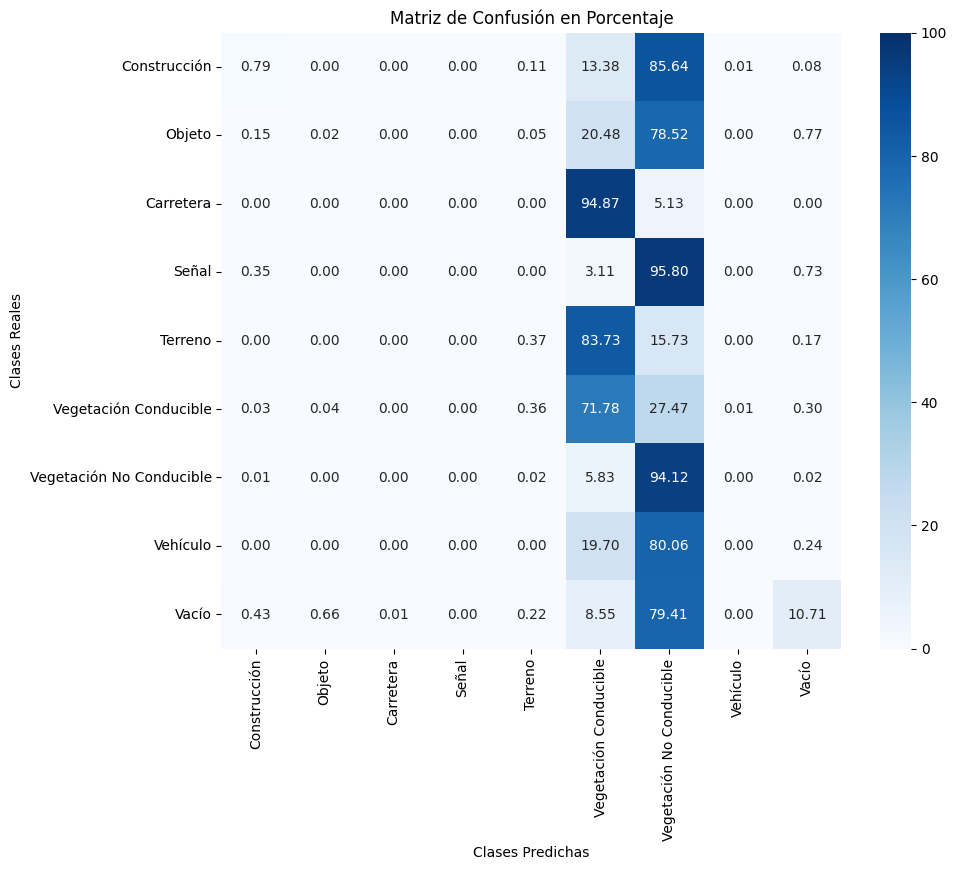

In [13]:
from sklearn.metrics import confusion_matrix

class_labels = {
    0: "Construcción",
    1: "Objeto",
    2: "Carretera",
    3: "Señal",
    4: "Terreno",
    5: "Vegetación Conducible",
    6: "Vegetación No Conducible",
    7: "Vehículo",
    8: "Vacío"
}

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_percentage(y_val, predicted_labels, num_classes=9, class_labels=None):
    y_true = y_val.flatten()
    y_pred = predicted_labels.flatten()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    if class_labels is None:
        class_labels = {i: f"Clase {i}" for i in range(num_classes)}

    class_names = [class_labels[i] for i in range(num_classes)]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=100)

    plt.xlabel("Clases Predichas")
    plt.ylabel("Clases Reales")
    plt.title("Matriz de Confusión en Porcentaje")
    plt.show()

plot_confusion_matrix_percentage(labels_list, preds_list, num_classes=9, class_labels=class_labels)


In [14]:
import plotly.graph_objects as go
import numpy as np

# Diccionario de clases de segmentación con las etiquetas agrupadas
class_labels = {
    0: "Construction",  # Gris
    1: "Object",  # Naranja
    2: "Road",  # Azul
    3: "Sign",  # Rojo
    4: "Terrain",  # Marrón
    5: "Drivable Vegetation",  # Verde claro
    6: "Non Drivable Vegetation",  # Verde oscuro
    7: "Vehicle",  # Amarillo
    8: "Void"  # Negro
}

# Asignación de colores específicos según la preferencia del usuario
color_mapping = {
    0: "gray",        # Construcción
    1: "orange",      # Objeto
    2: "blue",        # Carretera
    3: "red",         # Señales
    4: "brown",       # Terreno
    5: "lightgreen",  # Vegetación transitable
    6: "darkgreen",   # Vegetación no transitable
    7: "yellow",      # Vehículo
    8: "black"        # Vacío
}

def visualizar_comparacion_segmentacion(x_val, y_val, predicted_labels, indice):
    if indice >= len(x_val):
        print(f"Índice fuera de rango. Debe estar entre 0 y {len(x_val)-1}.")
        return

    # Extraer la nube de puntos y las etiquetas correspondientes
    puntos = x_val[indice]
    etiquetas_reales = y_val[indice]
    etiquetas_predichas = predicted_labels[indice]

    # Crear figuras separadas
    fig_real = go.Figure()
    fig_pred = go.Figure()

    for class_id, class_name in class_labels.items():
        indices = np.where(etiquetas_reales == class_id)[0]

        if len(indices) > 0:
            fig_real.add_trace(go.Scatter3d(
                x=puntos[indices, 0],
                y=puntos[indices, 1],
                z=puntos[indices, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping[class_id],
                    opacity=0.8
                ),
                name=f"[Real] {class_name}"
            ))

    for class_id, class_name in class_labels.items():
        indices = np.where(etiquetas_predichas == class_id)[0]

        if len(indices) > 0:
            fig_pred.add_trace(go.Scatter3d(
                x=puntos[indices, 0],
                y=puntos[indices, 1],
                z=puntos[indices, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping[class_id],
                    opacity=0.8
                ),
                name=f"[Predicho] {class_name}"
            ))

    # Configuración del gráfico de etiquetas reales
    fig_real.update_layout(
        title=f"Segmentación Real - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación"
    )

    # Configuración del gráfico de etiquetas predichas
    fig_pred.update_layout(
        title=f"Segmentación Predicha - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación"
    )

    # Mostrar ambas figuras
    fig_real.show()
    fig_pred.show()

In [15]:
visualizar_comparacion_segmentacion(points_list, labels_list, preds_list, indice=500)